0️⃣ Notebook Goal (Markdown)

Diagnose the true drivers of the observed engagement decline by correcting for selection bias, testing key assumptions, and decomposing aggregate metrics into causal and non-causal components.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import ttest_ind


In [4]:
users = pd.read_csv("data_design/users.csv", parse_dates=["signup_date"])
events = pd.read_csv("data_design/events.csv", parse_dates=["event_time", "first_seen"])
features = pd.read_csv("data_design/features.csv", parse_dates=["launch_date"])
calendar = pd.read_csv("data_design/calendar_effects.csv", parse_dates=["date"])


In [5]:
feature_launch = features.loc[0, "launch_date"]

events["date"] = events["event_time"].dt.date
events["post"] = (events["event_time"] >= feature_launch).astype(int)


In [6]:
pre_events = events[events["event_time"] < feature_launch]

user_features = (
    pre_events
    .groupby("user_id")
    .agg(
        pre_sessions=("event_time", "count"),
        pre_active_days=("date", "nunique")
    )
    .reset_index()
)


In [7]:
user_features = (
    user_features
    .merge(users, on="user_id", how="left")
)


In [8]:
treated_users = (
    events
    .query("post == 1 and feature_exposed == 1")["user_id"]
    .unique()
)

user_features["treated"] = user_features["user_id"].isin(treated_users).astype(int)


In [9]:
X = user_features[
    ["pre_sessions", "pre_active_days"]
]
y = user_features["treated"]


In [10]:
psm = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(max_iter=1000))
])

psm.fit(X, y)

user_features["propensity_score"] = psm.predict_proba(X)[:, 1]


treated
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: propensity_score, dtype: object

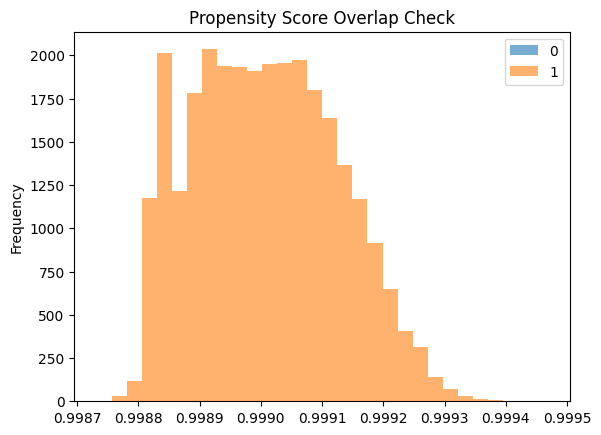

In [11]:
user_features.groupby("treated")["propensity_score"].plot(
    kind="hist",
    alpha=0.6,
    bins=30,
    legend=True,
    title="Propensity Score Overlap Check"
)


In [12]:
treated = user_features[user_features["treated"] == 1]
control = user_features[user_features["treated"] == 0]

control_matched = control.iloc[
    np.abs(
        control["propensity_score"].values[:, None] -
        treated["propensity_score"].values
    ).argmin(axis=0)
]

matched_users = pd.concat([treated, control_matched])


In [13]:
matched_users.groupby("treated")[["pre_sessions", "pre_active_days"]].mean()


,pre_sessions,pre_active_days
treated,,
0,14.207694,7.44959
1,13.517048,7.55342


In [15]:
matched_events = events.merge(
    matched_users[["user_id", "treated"]],
    on="user_id",
    how="inner"
)


In [16]:
def daily_esau(df):
    daily_sessions = df.groupby("date").size()
    daily_active_users = df.groupby("date")["user_id"].nunique()
    return daily_sessions / daily_active_users


In [17]:
esau_treated = daily_esau(
    matched_events[matched_events["treated"] == 1]
)

esau_control = daily_esau(
    matched_events[matched_events["treated"] == 0]
)


In [18]:
t_stat, p_val = ttest_ind(
    esau_treated,
    esau_control,
    equal_var=False
)

t_stat, p_val


(np.float64(-5.429897068819854), np.float64(6.680576850344081e-07))

In [19]:
daily_group = (
    matched_events
    .groupby(["date", "treated", "post"])
    .agg(
        sessions=("user_id", "count"),
        active_users=("user_id", "nunique")
    )
    .reset_index()
)

daily_group["esau"] = (
    daily_group["sessions"] /
    daily_group["active_users"]
)


In [20]:
import statsmodels.formula.api as smf

did_psm = smf.ols(
    "esau ~ treated + post + treated:post",
    data=daily_group
).fit()

did_psm.summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2660.9778,385.563,6.902,0.000,1899.635,3422.321
treated,-2659.1898,517.288,-5.141,0.000,-3680.639,-1637.741
post,-713.5601,594.193,-1.201,0.232,-1886.869,459.748
treated:post,713.5294,808.509,0.883,0.379,-882.973,2310.032
